# Predykcja kwoty napiwku za przejazd nowojorską taskówką

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import helper_functions as hf
import pyarrow.parquet as pq

# Wczytywanie danych

In [2]:
data = hf.load_data()

In [3]:
data.shape

(5972150, 19)

# Opis danych

Dane wykorzystane w analizie pochodzą z historycznych danych dotyczących przejazdów taksówkami w Nowym Jorku <a href="[url](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)" target="_blank">NYC Taxi & Limousine Commission - Trip Record Data</a>

In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


#### Zmienne niezależne:
VendorID: Kod wskazujący dostawcę TPEP (taksometrów), który dostarczył rekord.
* 1= Creative Mobile Technologies, LLC;
* 2= VeriFone Inc.
***
tpep_pickup_datetime: Data i czas, kiedy taksometr został uruchomiony. (Timestamp)
***
tpep_dropoff_datetime: Data i czas, kiedy taksometr został wyłączony. (Timestamp)
***
Passenger_count: Liczba pasażerów w pojeździe. (Liczba całkowita)
Wartość wprowadzana przez kierowcę.
***
Trip_distance: Przejechany dystans w milach, zgłoszony przez taksometr. (Liczna zmiennoprzecinkowa)
***
RateCodeID: Ostateczny kod taryfy obowiązujący na końcu podróży.
* 1 = Standardowa taryfa
* 2 = JFK
* 3 = Newark
* 4 = Nassau lub Westchester
* 5 = Uzgodniona opłata
* 6 = Podróż grupowa
***
Store_and_fwd_flag: Flaga wskazująca, czy zapis podróży został przechowany w pamięci pojazdu przed przesłaniem do dostawcy ("store and forward"), ponieważ pojazd nie miał połączenia z serwerem.

* Y = zapis przechowywany i przesłany później
* N = zapis nie przechowywany
***
PULocationID: Rejon w którym taksometr został włączony. (Liczba całkowita)
***
DOLocationID: Rejon, w którym taksometr został wyłączony. (Liczba całkowita)
***
Payment_type: Kod numeryczny wskazujący sposób zapłaty pasażera za podróż.
* 1 = Karta kredytowa
* 2 = Gotówka
* 3 = Brak opłaty
* 4 = Spór
* 5 = Nieznane
* 6 = Anulowana podróż
***
Fare_amount: Opłata za czas i dystans obliczona przez taksometr. (Liczna zmiennoprzecinkowa)
***
Extra: Dodatkowe opłaty i dopłaty. Obecnie obejmuje jedynie dopłaty $0,50 i $1 za godziny szczytu oraz nocne. (Liczna zmiennoprzecinkowa)
***
MTA_tax: Podatek MTA w wysokości $0,50, który jest automatycznie naliczany w zależności od używanej taryfy. (Liczna zmiennoprzecinkowa)
***
Improvement_surcharge: Dopłata w wysokości $0,30, która jest naliczana przy rozpoczęciu podróży. Dopłatę wprowadzono w 2015 roku. (Liczna zmiennoprzecinkowa)
***
Tolls_amount: Łączna kwota wszystkich opłat za przejazdy w trakcie podróży. (Liczna zmiennoprzecinkowa)
***
Total_amount: Całkowita kwota naliczona pasażerom. Nie obejmuje napiwków gotówkowych. (Liczna zmiennoprzecinkowa)
***
congestion_surcharge: Dodatkowa opłata naliczana pasażerom za podróż przez najbardziej zatłoczone części miasta (Liczna zmiennoprzecinkowa)
***
Airport_fee: Opłata naliczana za przejazdy realizowane na lub z określonych lotnisk w mieście. Jest to stała opłata dodawana do całkowitego kosztu przejazdu. (Liczna zmiennoprzecinkowa)

#### Zmienna zależna:
Tip_amount: Kwota napiwku – to pole jest automatycznie wypełniane w przypadku napiwków opłacanych kartą kredytową. Napiwki gotówkowe nie są uwzględnione. (Liczna zmiennoprzecinkowa)

### Celem analizy jest stworzenie skutecznego modelu prognozującego kwotę napiwku za przejazd pozwoli na identyfikację zmiennych posiadających największy wpływ na jej wielkość. Posiadając tą wiedzę można zastosować ją aby osiągnąć następujące korzyści:
* Zwiększenie wynagrodzenia kierowców poprzez wskazanie strategii, które sprzyjają wyższym napiwkom
* Efektywne zarządzanie flotą poprzez kierowanie pojazdów w miejsca i czasy, gdzie możliwe są wyższe napiwki
*  Usprawnienie planowania finansowego
*  Proaktywne zarządzanie skargami pasażerów i poprawa jakości usług

# Analiza jakości danych źródłowych

### Duplikaty

In [5]:
duplicates_indexes = hf.get_duplicates_indexes(data)
data.loc[duplicates_indexes]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
3718872,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,1.0,N,162,230,1,12.8,2.5,0.5,3.86,0.0,1.0,23.16,2.5,0.0
3718876,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,1.0,N,162,230,1,12.8,2.5,0.5,3.86,0.0,1.0,23.16,2.5,0.0


W całym zbiorze znajduje się jedynie 8 duplikatów

### Wartości odstające - Wykresy pudełkowe

Dostawca taksometru

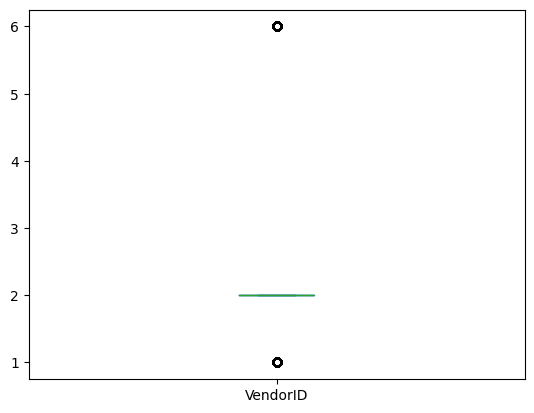

In [6]:
data["VendorID"].plot(kind="box")
plt.show()

In [7]:
data["VendorID"].unique()

array([2, 1, 6])

W słowniku danych nie ma informacji o dostawcy systemu TPEP kodowanym numerem 6. Możliwe, że są to dane testowe? Zostaną usunięte przed dalszą analizą. W przypadku pracy z klientem biznesowym należałoby zapytać co oznacza taki kod dostawcy.

Liczba pasażerów

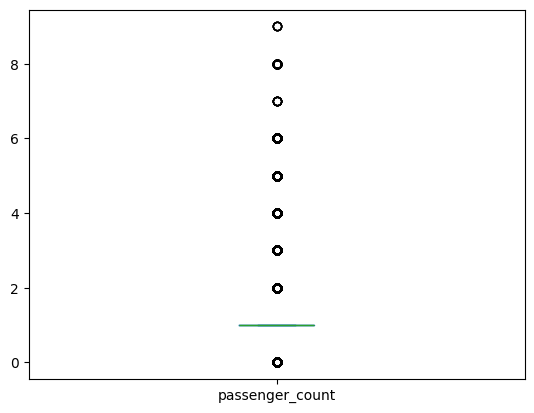

In [8]:
data["passenger_count"].plot(kind="box")
plt.show()

In [9]:
data["passenger_count"].unique()

array([ 1.,  2.,  0.,  4.,  3.,  5.,  6.,  8.,  7.,  9., nan])

Odległość podróży

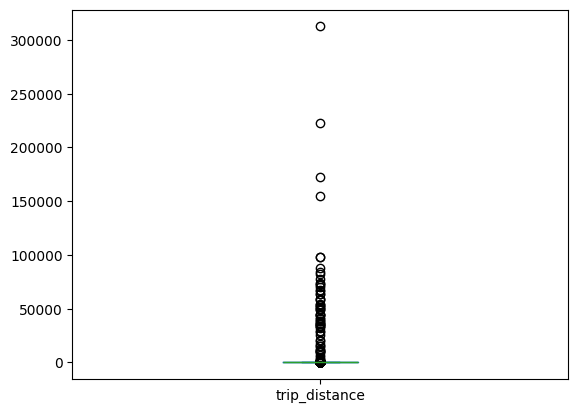

In [10]:
data["trip_distance"].plot(kind="box")
plt.show()

In [11]:
data["trip_distance"].median()

1.69

Z wykresu widać, że długość niektórych przejazdów jest musi wynikać z błędów (przeciętna taksówka w Nowym Yorku przejeżdża rocznie 70000 mil, a niektóre wartości tej kolumny to przebijają). Zostaną odfiltrowane pojedyncze kursy dłuższe niż 200 mil czyli dzienny przebieg Nowojorskiej taksówki

Całkowita kwota do zapłaty

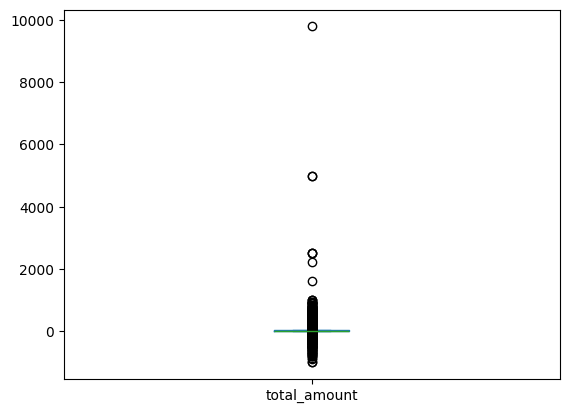

In [12]:
data["total_amount"].plot(kind="box")
plt.show()

Na wykresie widać, że część wartości jest ujemna. Ujemna kwota opłaty może oznaczać zwrot nieprawidłowo naliczonej kwoty za przejazd. Wiersze z tymi wartościami również zostaną odfiltrowane. 

### Wartości brakujące

In [13]:
nan_df = hf.get_missing_values(data)
nan_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2824462,2,2024-01-01 00:34:19,2024-01-01 00:51:22,NaN,2.04,NaN,None,143,141,0,12.72,0.0,0.5,0.00,0.0,1.0,16.72,NaN,NaN
2824463,1,2024-01-01 00:14:31,2024-01-01 00:19:29,NaN,1.60,NaN,None,236,238,0,9.30,1.0,0.5,2.86,0.0,1.0,17.16,NaN,NaN
2824464,1,2024-01-01 00:35:11,2024-01-01 01:13:40,NaN,0.00,NaN,None,142,79,0,21.01,0.0,0.5,0.00,0.0,1.0,25.01,NaN,NaN
2824465,1,2024-01-01 00:33:37,2024-01-01 00:50:34,NaN,0.00,NaN,None,237,4,0,17.79,0.0,0.5,0.00,0.0,1.0,21.79,NaN,NaN
2824466,1,2024-01-01 00:49:04,2024-01-01 01:01:16,NaN,0.00,NaN,None,244,50,0,34.65,0.0,0.5,0.00,0.0,1.0,38.65,NaN,NaN


In [14]:
nan_df.shape

(325772, 19)

In [15]:
nans_in_columns = hf.get_nan_counts_for_columns(data)
nans_in_columns

,column_name,nan_count
0,VendorID,0
1,tpep_pickup_datetime,0
2,tpep_dropoff_datetime,0
3,passenger_count,325772
4,trip_distance,0
5,RatecodeID,325772
6,store_and_fwd_flag,325772
7,PULocationID,0
8,DOLocationID,0
9,payment_type,0


W zbiorze znjduje się 3391267 wierszy z wartościami brakującymi. Jeżeli w wierszu znajdują się wartości brakujące to zawsze w pięciu kolumnach: passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge oraz Airport_fee. 

In [16]:
for column in nan_df.columns:
    print(column, len(nan_df[column].unique()))

VendorID 3
tpep_pickup_datetime 298424
tpep_dropoff_datetime 298693
passenger_count 1
trip_distance 2518
RatecodeID 1
store_and_fwd_flag 1
PULocationID 251
DOLocationID 251
payment_type 1
fare_amount 8512
extra 17
mta_tax 4
tip_amount 2190
tolls_amount 196
improvement_surcharge 3
total_amount 10087
congestion_surcharge 1
Airport_fee 1


In [17]:
len(nan_df[nan_df["payment_type"] == 0])

325772

Wszystkie wiersze z wartościami brakującymi posiadają wartość payment_type = 0. Wskazuje to że mechanizm ich powstania to MAR (Missing at random).

# Przetwarzanie danych

### Odfiltrowanie zbyt długich przejazdów, ujemnych opłat oraz VendorID nie wymienianego w słowniku danych

In [18]:
rows_before = data.shape[0]
data = hf.filter_weird_values(data)
rows_after = data.shape[0]
print(f"Removed {rows_before - rows_after} rows")

Removed 72773 rows


### Augmentacja - dodawanie zmiennych

In [19]:
data["is_weekend"] = data["tpep_pickup_datetime"].apply(hf.is_weekend)

In [20]:
data["rush_hours"] = data["tpep_pickup_datetime"].apply(hf.is_rush_hour)

In [21]:
data["day_of_week"] = data["tpep_pickup_datetime"].apply(hf.what_weekday)

In [22]:
data["month"] = data["tpep_pickup_datetime"].apply(hf.what_month)

### Zamiana kodowania zmiennej store_and_fwd_flag z ("Y", "N") na (1.0, 0.0)

In [23]:
data.loc[:,"store_and_fwd_flag"] = data["store_and_fwd_flag"].apply(lambda x: 1.0 if x == "Y" else 0.0)

### Zamiana zapisu zmiennych "day_of_week" oraz "month" za pomocą enkodera binarnego

In [24]:
from category_encoders import BinaryEncoder

encoder = BinaryEncoder(cols=["day_of_week", "month"])

data = encoder.fit_transform(data)
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,Airport_fee,is_weekend,rush_hours,day_of_week_0,day_of_week_1,day_of_week_2,month_0,month_1,month_2
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,0.0,186,79,2,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,0.0,140,236,1,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,0.0,236,79,1,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,0.0,79,211,1,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,0.0,211,148,1,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1


### Uzupełnienie danych brakujących
Dane brakujące zostaną uzupełnione mediana dla zmiennych RatecodeID, store_and_fwd_flag, passenger_count, congestion_surcharge oraz Airport_fee.

In [25]:
data = hf.impute_missing_values(data)

c:\Users\grzec\studia\ds360\helper_functions.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[['store_and_fwd_flag']] = data[['store_and_fwd_flag']].fillna(0.0)


### Usunięcie kolumn "tpep_pickup_datetime"	"tpep_dropoff_datetime"

In [26]:
data = data.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

In [27]:
data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,congestion_surcharge,Airport_fee,is_weekend,rush_hours,day_of_week_0,day_of_week_1,day_of_week_2,month_0,month_1,month_2
0,2,1.0,1.72,1.0,0.0,186,79,2,17.7,1.0,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
1,1,1.0,1.80,1.0,0.0,140,236,1,10.0,3.5,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
2,1,1.0,4.70,1.0,0.0,236,79,1,23.3,3.5,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
3,1,1.0,1.40,1.0,0.0,79,211,1,10.0,3.5,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1
4,1,1.0,0.80,1.0,0.0,211,148,1,7.9,3.5,...,2.5,0.0,0.0,0.0,0,0,1,0,0,1


# Budowanie modeli

In [28]:
from sklearn.model_selection import train_test_split

### Definicja zmiennych wejściowych i wyjściowych

In [29]:
X = data.drop(columns=["tip_amount"])
y = data["tip_amount"]

### Podział na zbiór treningowy i testowy

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Selekcja cech

In [31]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=11)
rfe.fit(X, y)

feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
feature_ranking.sort_values(by='Ranking')

,Feature,Ranking
0,VendorID,1
15,Airport_fee,1
14,congestion_surcharge,1
13,total_amount,1
12,improvement_surcharge,1
10,mta_tax,1
9,extra,1
8,fare_amount,1
11,tolls_amount,1
4,store_and_fwd_flag,1


In [32]:
features_to_drop = feature_ranking[feature_ranking["Ranking"] != 1]
features_to_drop

,Feature,Ranking
1,passenger_count,12
2,trip_distance,6
3,RatecodeID,7
5,PULocationID,14
6,DOLocationID,13
16,is_weekend,5
17,rush_hours,4
18,day_of_week_0,11
19,day_of_week_1,8
20,day_of_week_2,10


### Odrzucenie zmiennych które uzyskały najniższe wyniki w rankingu

In [33]:
X = X.drop(columns=features_to_drop["Feature"].values)


In [34]:
X.head()

,VendorID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,0.0,2,17.7,1.0,0.5,0.0,1.0,22.70,2.5,0.0
1,1,0.0,1,10.0,3.5,0.5,0.0,1.0,18.75,2.5,0.0
2,1,0.0,1,23.3,3.5,0.5,0.0,1.0,31.30,2.5,0.0
3,1,0.0,1,10.0,3.5,0.5,0.0,1.0,17.00,2.5,0.0
4,1,0.0,1,7.9,3.5,0.5,0.0,1.0,16.10,2.5,0.0


### Uczenie modelu regresja linowa 

In [35]:
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
regr.score(X_test, y_test)

0.9891677429671781

### Uczenie modelu regresja grzbietowa (ridge regression)

In [36]:
from sklearn.linear_model import Ridge

rdg = Ridge(alpha = 0.5)
rdg.fit(X_train, y_train)
rdg.score(X_test, y_test)

0.9891677424986252

### Uczenie modelu regresja Lasso

In [37]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

0.9684881572527199

### Dostrajanie hiperparametrów
Regresja grzbietowa

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

ridge_grid_search = GridSearchCV(estimator=rdg, param_grid=param_grid, cv=5)

ridge_grid_search.fit(X_train, y_train)

ridge_grid_search.best_params_

Regresja Lasso

In [ ]:
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-4, 1e-3, 1e-2],
}


lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5)

lasso_grid_search.fit(X_train, y_train)

lasso_grid_search.best_params_

# Mierzenie jakości modeli
 Root Mean Square Error

In [38]:
regr_predictions = regr.predict(X_test)

rdg_predictions = rdg.predict(X_test)

lasso_predictions = lasso.predict(X_test)

In [39]:
from sklearn.metrics import root_mean_squared_error

rmse_rdg = root_mean_squared_error(y_test, rdg_predictions)
rmse_rdg

0.4001499647806044

In [41]:
rmse_regr = root_mean_squared_error(y_test, regr_predictions)
rmse_regr

0.40014995612629267

In [40]:
rmse_lasso = root_mean_squared_error(y_test, lasso_predictions)
rmse_lasso

0.6824961338919021

# Wnioski

Stworzenie modeli prognostycznych ze zmiennymi: VendorID,	store_and_fwd_flag,	payment_type, fare_amount,	extra,	mta_tax,	tolls_amount,	improvement_surcharge,	total_amount,	congestion_surcharge oraz	Airport_fee pozwoliło na uzyskanie wysokiej jakości predykcji kwoty napiwku za przejazd. Najgorsze wyniki osiągnął model Lasso jednak w tym przypadku może to wynikać z niedostrojonych hiperparametrów. 